<a href="https://colab.research.google.com/github/chirongaA/dataanalytics/blob/master/Chironga_Text_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SCS 3312:	 BUSINESS INTELLIGENCE & ANALYTICS

PRACTICUM ASSIGNMENT III : TEXT ANALYTICS

This Notebook highlights text analytics processes undertaken on a FlipKart Products Review dataset that references Porter's Five Forces Model.
- The task requires a description of a pipeline of tasks starting from data collection to Insight Generation and Visualization.
- With reference to the Bargaining Power of Buyers, Sentiment Analysis is required to be undertaken to analyse customer reviews ans social media for negative sentiment related to price, lack of features or poor service.
- Lastly, Topic Modelling should be done to identify key mentions/topics related to either new entrants or competitors, disruptive technologies, alternative products or services, Pain Points or key areas where competition is focused.

## PRELIMINARIES

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import spacy
from collections import Counter
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/My Drive/flipkart_product.xlsx')

#Display the first few rows of the data
print(f"Shape of dataset: {df.shape}")
df.head(5)

Mounted at /content/drive
Shape of dataset: (189874, 5)


,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",3,Fair,Ok ok product


In [ ]:
# Display basic information
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
display(df.head())

# Basic statistics
print("\nBasic statistics for numerical columns:")
display(df.describe())

Dataset shape: (189874, 5)

Column names: ['ProductName', 'Price', 'Rate', 'Review', 'Summary']

Data types:
ProductName    object
Price          object
Rate           object
Review         object
Summary        object
dtype: object

First few rows:


,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"ƒ??3,999",3,Fair,Ok ok product



Basic statistics for numerical columns:


,ProductName,Price,Rate,Review,Summary
count,189874,189873,189873,189870,189854
unique,812,561,9,1264,98342
top,MILTON Thermosteel Flip Lid 500 ml FlaskÂ Â (P...,"â‚¹1,299",5,Nan,Good
freq,9278,10005,108694,20862,14175


In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
ProductName     0
Price           1
Rate            1
Review          4
Summary        20
dtype: int64


In [ ]:
# Text length analysis
df['text_length'] = df['Review'].astype(str).apply(len) # change the datatype to string
print("\nText length statistics:")
print(df['text_length'].describe())


Text length statistics:
count    189874.000000
mean         11.526612
std           5.654454
min           2.000000
25%           9.000000
50%          10.000000
75%          16.000000
max         140.000000
Name: text_length, dtype: float64


## TEXT PREPROCESSING FUNCTIONS

-> In this section we'll deal with the following functions:

A. Function to clean the text data by:

1.   Converting to lowercase
2.   Removing punctuation
3.   Removing numbers
4.   Removing extra whitespace

B. Function to tokenize text into words

C. Function to remove stopwords from tokenized text

D. Function to lemmatize tokens

E. Complete preprocessing pipeline

In [ ]:
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove punctuation
        text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

In [ ]:
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return []

In [62]:
def remove_stopwords(tokens, custom_stopwords=None):
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    return [word for word in tokens if word not in stop_words and word != 'nan']


In [ ]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [ ]:
def preprocess_text(text, custom_stopwords=None):
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    tokens_without_stopwords = remove_stopwords(tokens, custom_stopwords)
    lemmatized_tokens = lemmatize_tokens(tokens_without_stopwords)
    return ' '.join(lemmatized_tokens)

In [ ]:
nltk.download('punkt_tab')

# Handle missing values (replace NaN with empty strings)
df['Review'] = df['Review'].fillna('')

# Apply preprocessing to the text column
print("Preprocessing text data...")
text_column = 'Review'
df['cleaned_text'] = df[text_column].apply(clean_text)

# Always create 'rating_num' and 'sentiment', handling missing 'rating'
df['rating_num'] = pd.to_numeric(df['Rate'], errors='coerce')  # Create even if 'rating' is missing
df['sentiment'] = df['rating_num'].apply(lambda x: 1 if x >= 3.0 else 0)

# Continue with preprocessing for other tasks
df['processed_text'] = df['cleaned_text'].apply(lambda x: preprocess_text(x, custom_stopwords=None))

# Display results of preprocessing
print("\nResults of preprocessing:")
# Check if 'rating' exists before including it in the display
if 'Rate' in df.columns:
    display(df[[text_column, 'cleaned_text', 'Rate', 'rating_num', 'sentiment']].head())
else:
    display(df[[text_column, 'cleaned_text', 'rating_num', 'sentiment']].head())  # Exclude 'rating'

# Display samples of processed text
print("\nSamples of processed text:")
for i in range(min(3, len(df))):
    print(f"\nOriginal Sample {i+1}:")
    print(df[text_column].iloc[i][:100] + "..." if len(df[text_column].iloc[i]) > 100 else df[text_column].iloc[i])
    print(f"\nProcessed Sample {i+1}:")
    print(df['processed_text'].iloc[i][:100] + "..." if len(df['processed_text'].iloc[i]) > 100 else df['processed_text'].iloc[i])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Preprocessing text data...

Results of preprocessing:


,Review,cleaned_text,Rate,rating_num,sentiment
0,Super!,super,5,5.0,1
1,Awesome,awesome,5,5.0,1
2,Fair,fair,3,3.0,1
3,Useless product,useless product,1,1.0,0
4,Fair,fair,3,3.0,1



Samples of processed text:

Original Sample 1:
Super!

Processed Sample 1:
super

Original Sample 2:
Awesome

Processed Sample 2:
awesome

Original Sample 3:
Fair

Processed Sample 3:
fair


from matplotlib import pyplot as plt
_df_0['rating_num'].plot(kind='hist', bins=20, title='rating_num')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('cleaned_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Rate').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='rating_num', y='sentiment', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['rating_num'].plot(kind='line', figsize=(8, 4), title='rating_num')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['sentiment'].plot(kind='line', figsize=(8, 4), title='sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['cleaned_text'].value_counts()
    for x_label, grp in _df_8.groupby('Review')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Review')
_ = plt.ylabel('cleaned_text')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Rate'].value_counts()
    for x_label, grp in _df_9.groupby('cleaned_text')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('cleaned_text')
_ = plt.ylabel('Rate')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['Review'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='rating_num', y='Review', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_11['cleaned_text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_11, x='rating_num', y='cleaned_text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Rate'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='rating_num', y='Rate', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Review'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='sentiment', y='Review', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

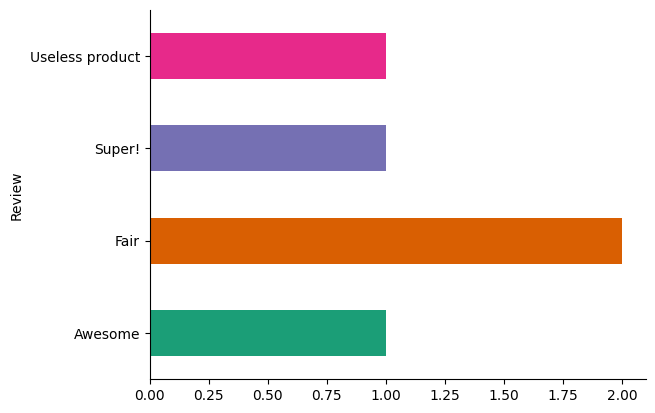

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

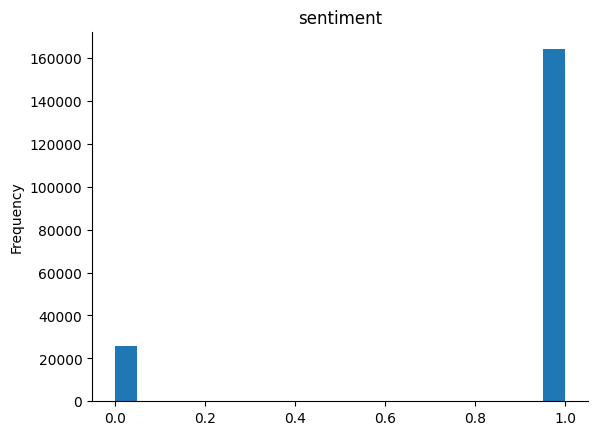

In [ ]:
from matplotlib import pyplot as plt
df['sentiment'].plot(kind='hist', bins=20, title='sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

## BASIC TEXT STATISTICS & ANALYSIS

Text statistics:


,word_count,char_count,avg_word_length
count,189874.000000,189874.000000,189874.000000
mean,1.492332,9.923270,5.704764
std,0.829790,5.906996,2.757688
min,0.000000,0.000000,0.000000
25%,1.000000,5.000000,4.000000
50%,2.000000,10.000000,6.000000
75%,2.000000,14.000000,8.000000
max,14.000000,103.000000,14.000000


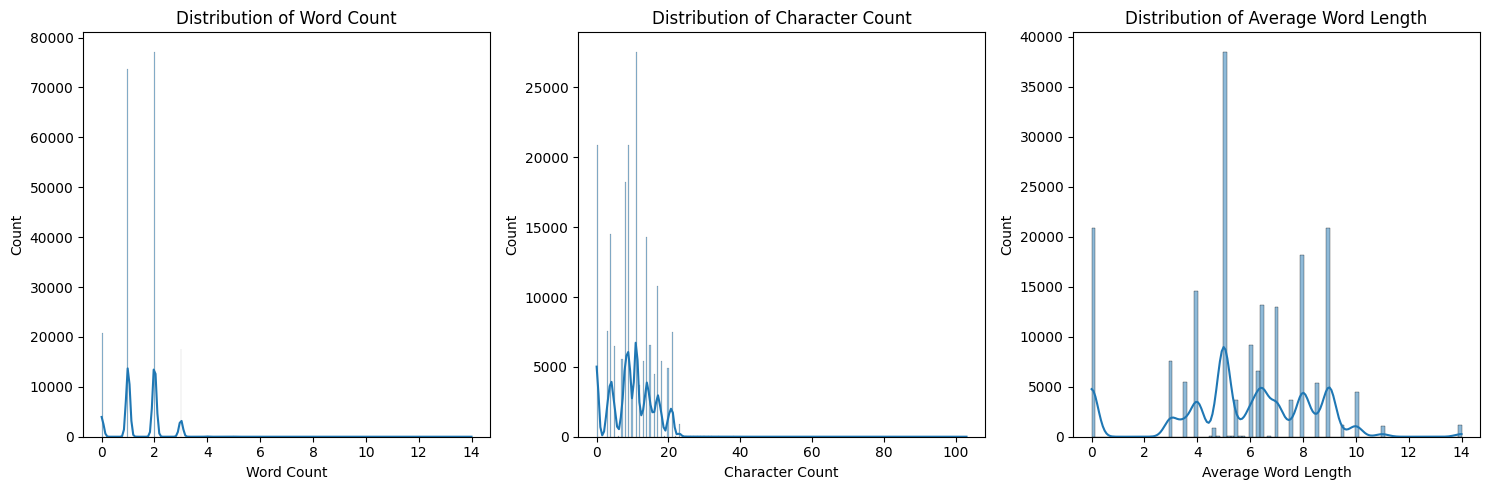

In [ ]:
# Word count per document
df['word_count'] = df['processed_text'].apply(lambda x: len(str(x).split()))

# Character count
df['char_count'] = df['processed_text'].apply(len)

# Average word length
df['avg_word_length'] = df['processed_text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)

# Display statistics
print("Text statistics:")
display(df[['word_count', 'char_count', 'avg_word_length']].describe())

# Plot histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')

plt.subplot(1, 3, 2)
sns.histplot(df['char_count'], kde=True)
plt.title('Distribution of Character Count')
plt.xlabel('Character Count')

plt.subplot(1, 3, 3)
sns.histplot(df['avg_word_length'], kde=True)
plt.title('Distribution of Average Word Length')
plt.xlabel('Average Word Length')

plt.tight_layout()
plt.show()

### Word Frequency Analysis

In [ ]:
def get_top_ngrams(corpus, n=1, top=20):
    # Get top n-grams from corpus
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

# Get top unigrams
top_unigrams = get_top_ngrams(df['processed_text'].tolist(), n=1, top=20)
unigram_df = pd.DataFrame(top_unigrams, columns=['Unigram', 'Frequency'])
print("Top 20 Unigrams:")
display(unigram_df)

# Get top bigrams
top_bigrams = get_top_ngrams(df['processed_text'].tolist(), n=2, top=20)
bigram_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])
print("\nTop 20 Bigrams:")
display(bigram_df)

Top 20 Unigrams:


,Unigram,Frequency
0,product,29314
1,good,17572
2,awesome,10938
3,purchase,10712
4,terrific,10677
5,nice,9490
6,money,9454
7,worth,8983
8,wonderful,8933
9,recommended,6459



Top 20 Bigrams:


,Bigram,Frequency
0,worth every,5471
1,every penny,5471
2,classy product,5439
3,best market,5434
4,great product,5431
5,mind blowing,5404
6,must buy,5403
7,blowing purchase,5401
8,perfect product,5400
9,simply awesome,5378


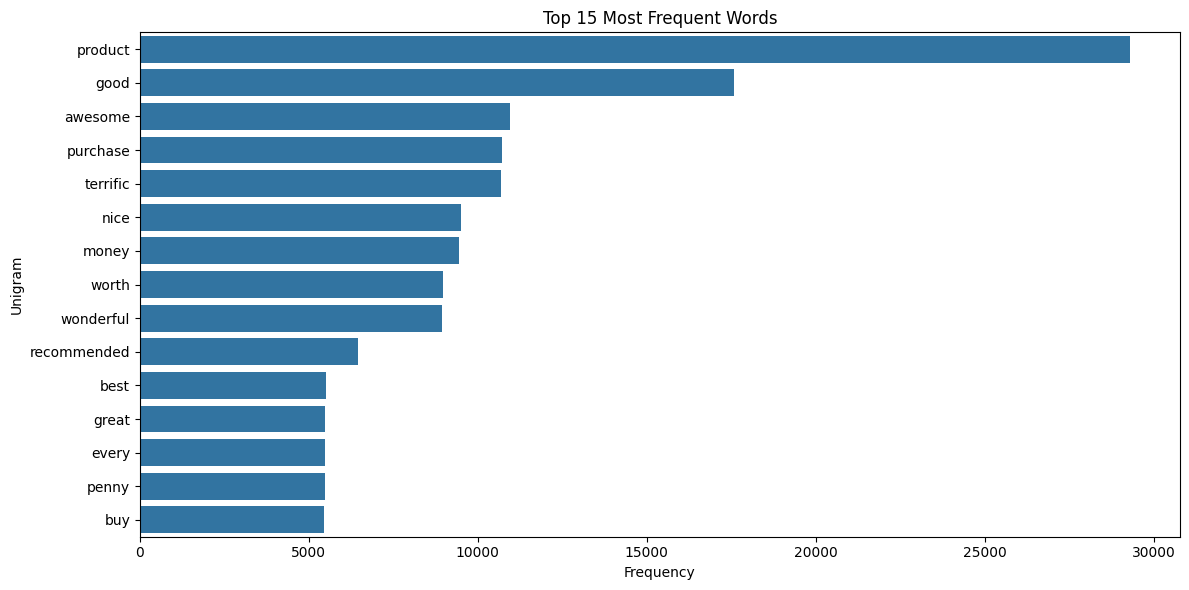

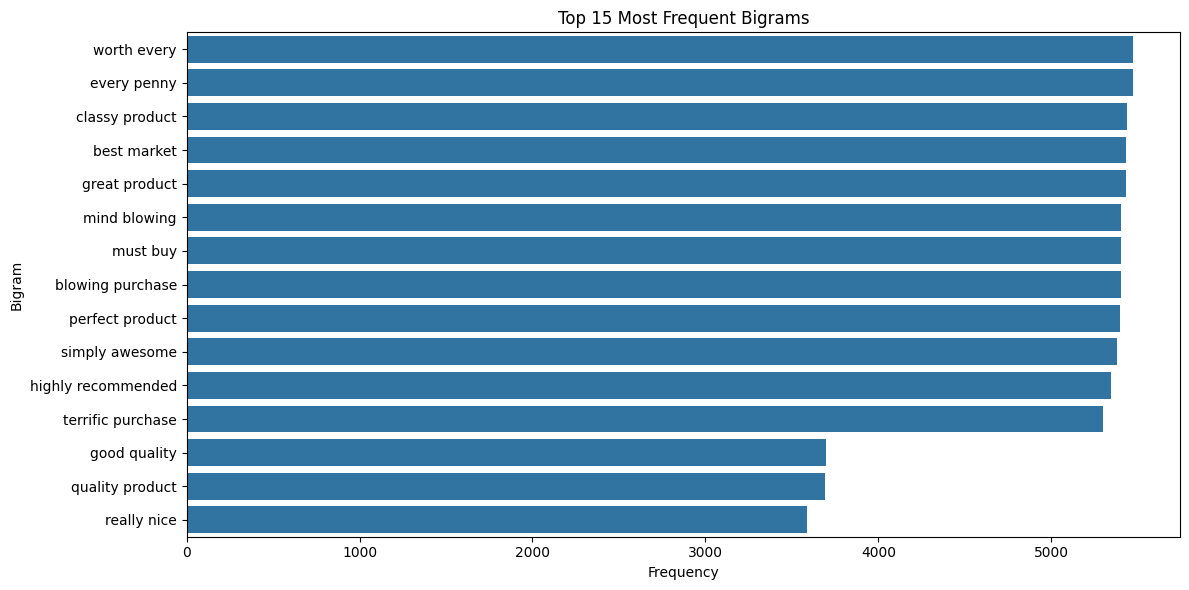

In [ ]:
# Visualize top unigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Unigram', data=unigram_df.head(15))
plt.title('Top 15 Most Frequent Words')
plt.tight_layout()
plt.show()

# Visualize top bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Bigram', data=bigram_df.head(15))
plt.title('Top 15 Most Frequent Bigrams')
plt.tight_layout()
plt.show()

### Word Cloud Visualization

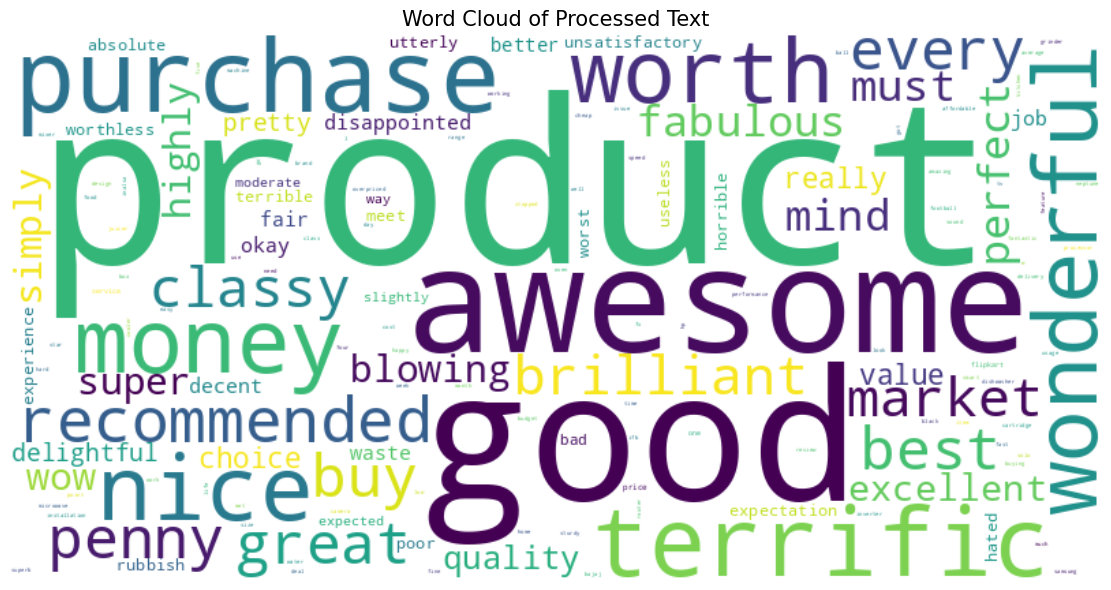

In [ ]:
# Function to create and display wordcloud
def plot_wordcloud(text_series, title):
    all_text = ' '.join(text_series.fillna('').astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=150, collocations=False).generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.tight_layout()
    plt.show()

# Create wordcloud from processed text
plot_wordcloud(df['processed_text'], 'Word Cloud of Processed Text')

## 8. Sentiment Analysis

In [ ]:
# Perform sentiment analysis using VADER
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to original text (not processed)
df['sentiment_scores'] = df[text_column].apply(lambda x: sia.polarity_scores(str(x)) if pd.notnull(x) else None)
df['compound_sentiment'] = df['sentiment_scores'].apply(lambda x: x['compound'] if x else None)
df['sentiment_category'] = df['compound_sentiment'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

# Display sentiment distribution
print("Sentiment Distribution:")
sentiment_counts = df['sentiment_category'].value_counts()
display(sentiment_counts)

Sentiment Distribution:


,count
sentiment_category,
positive,130787
neutral,44460
negative,14627


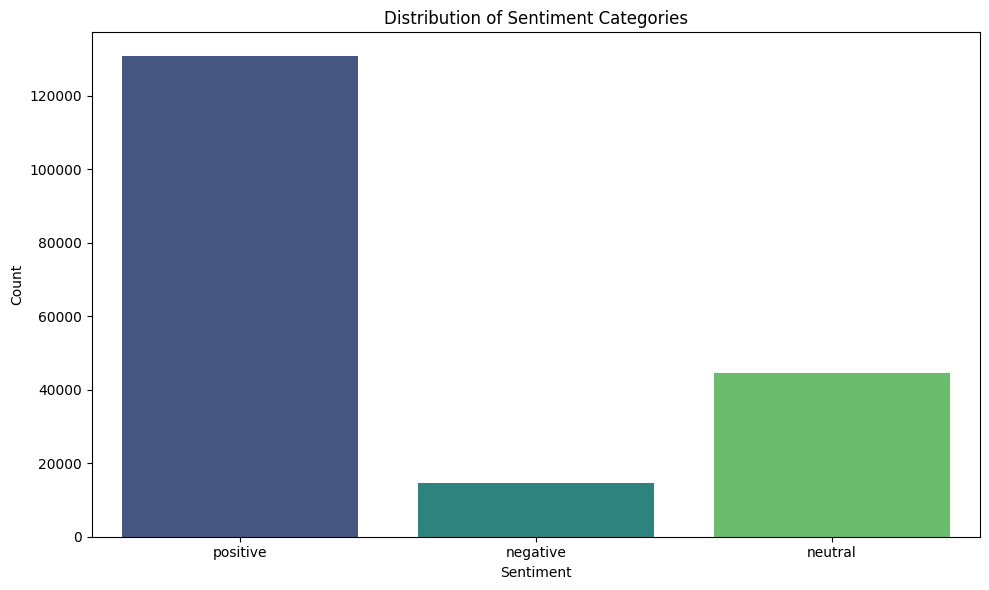

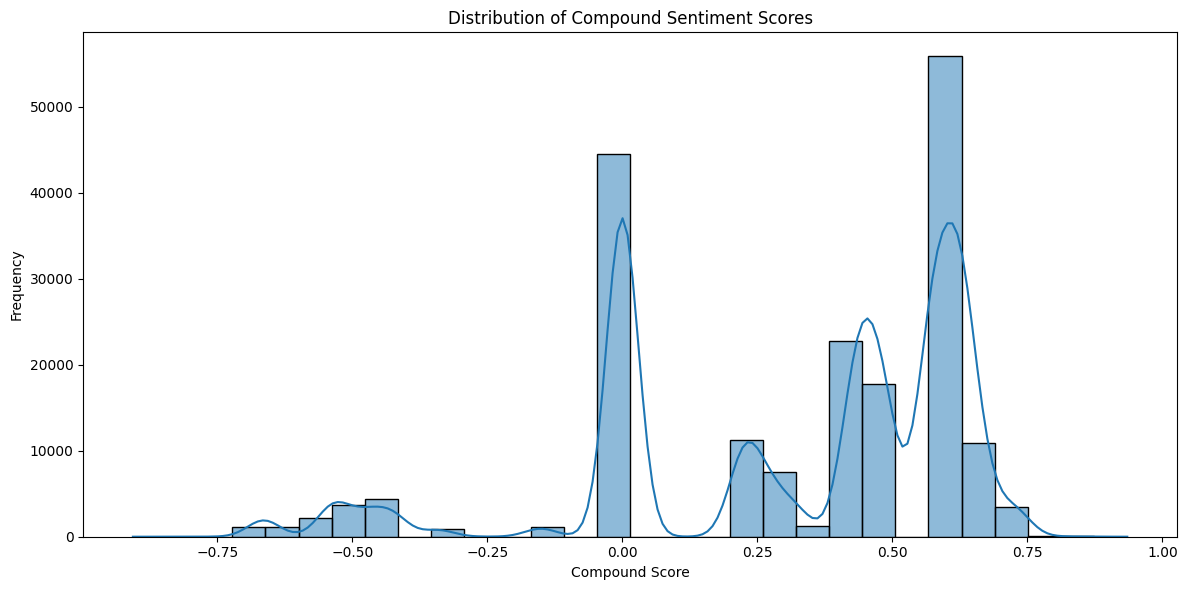

In [ ]:
# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_category', data=df, palette='viridis')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot sentiment compound scores
plt.figure(figsize=(12, 6))
sns.histplot(df['compound_sentiment'], kde=True, bins=30)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Topic Modeling with LDA

In [ ]:
# Create a document-term matrix
vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=2, stop_words='english') # Includes unigrams and bigrams
dtm = vectorizer.fit_transform(df['processed_text'].fillna(''))

# Set number of topics
n_topics = 5  # Adjust based on your needs

# Build LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=20)
lda_output = lda_model.fit_transform(dtm)

# Function to display topics
def print_topics(model, feature_names, n_top_words):
    topics_df = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics_df[f'Topic {topic_idx+1}'] = top_words
    return topics_df

In [ ]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Display topics
topics_df = print_topics(lda_model, feature_names, 10)
print("Top 5 words in each topic:")
display(topics_df)

# Add dominant topic to dataframe
df['dominant_topic'] = lda_output.argmax(axis=1) + 1  # +1 for 1-based indexing

Top 5 words in each topic:


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,product,nice,good,awesome,best
1,purchase,product,fabulous,wonderful,market
2,terrific,recommended,pretty,product,best market
3,buy,money,pretty good,worth,wow
4,classy,brilliant,absolute,great,fair
5,classy product,highly,rubbish,penny,product
6,perfect,highly recommended,absolute rubbish,worth penny,poor
7,mind blowing,quality,disappointed,great product,worst
8,mind,good quality,utterly,simply,experience
9,blowing,quality product,utterly disappointed,super,worst experience


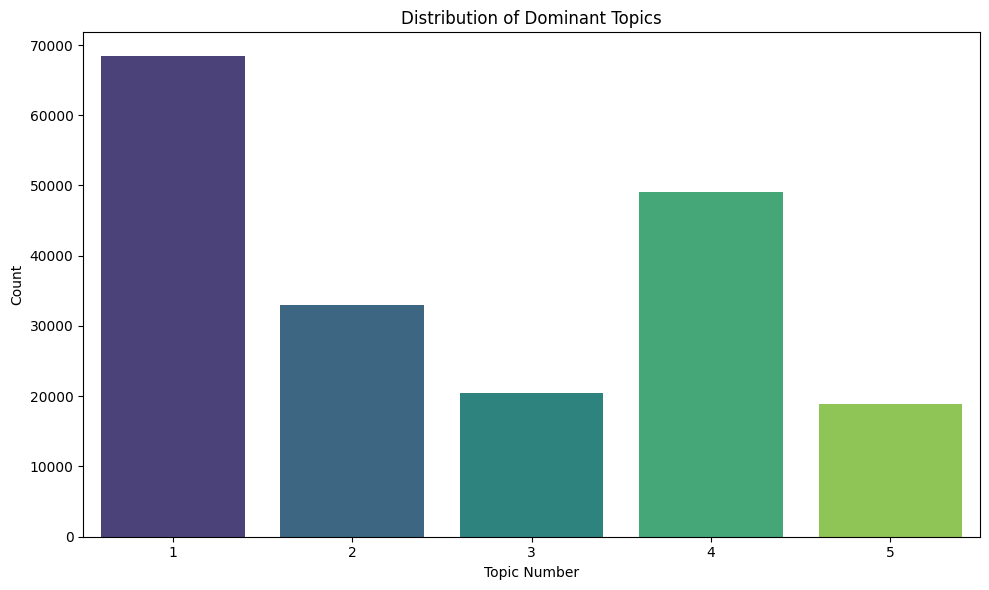

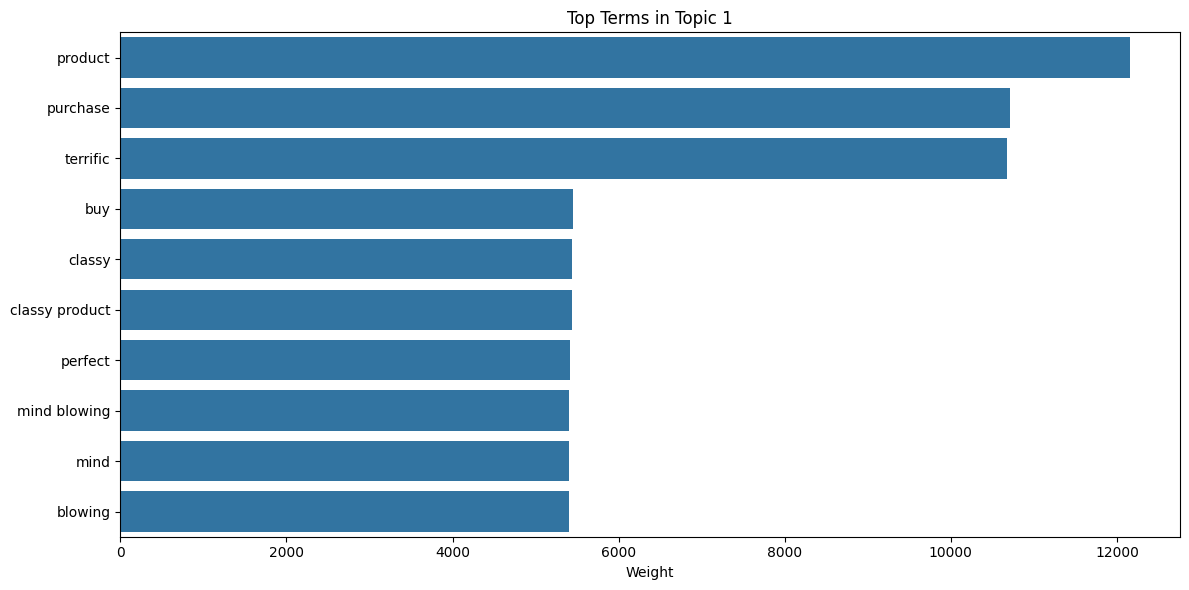

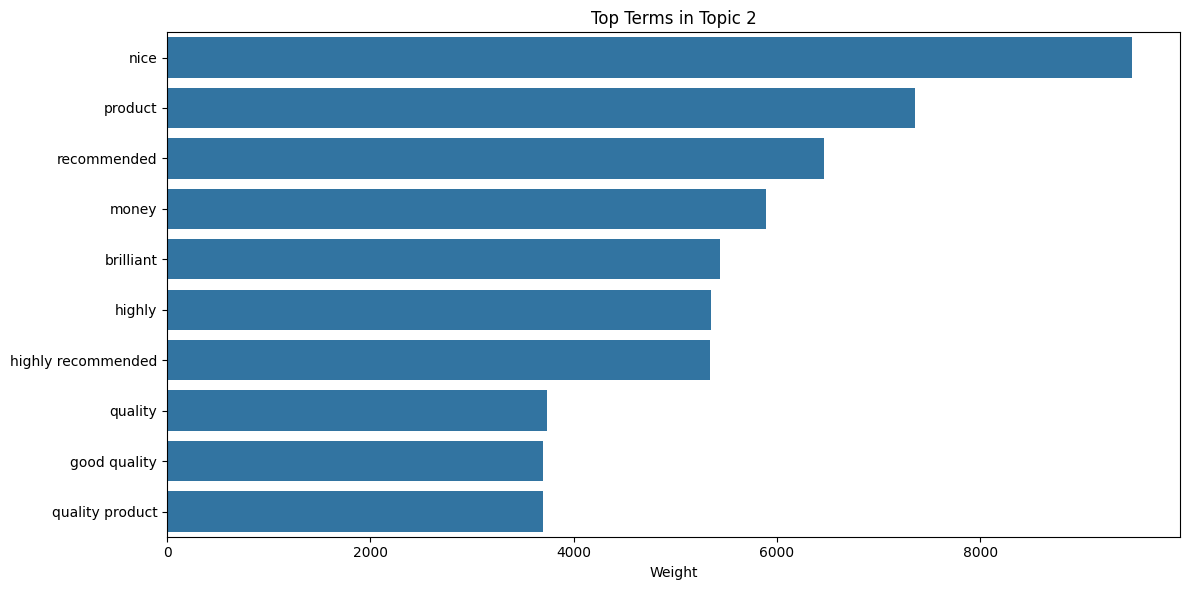

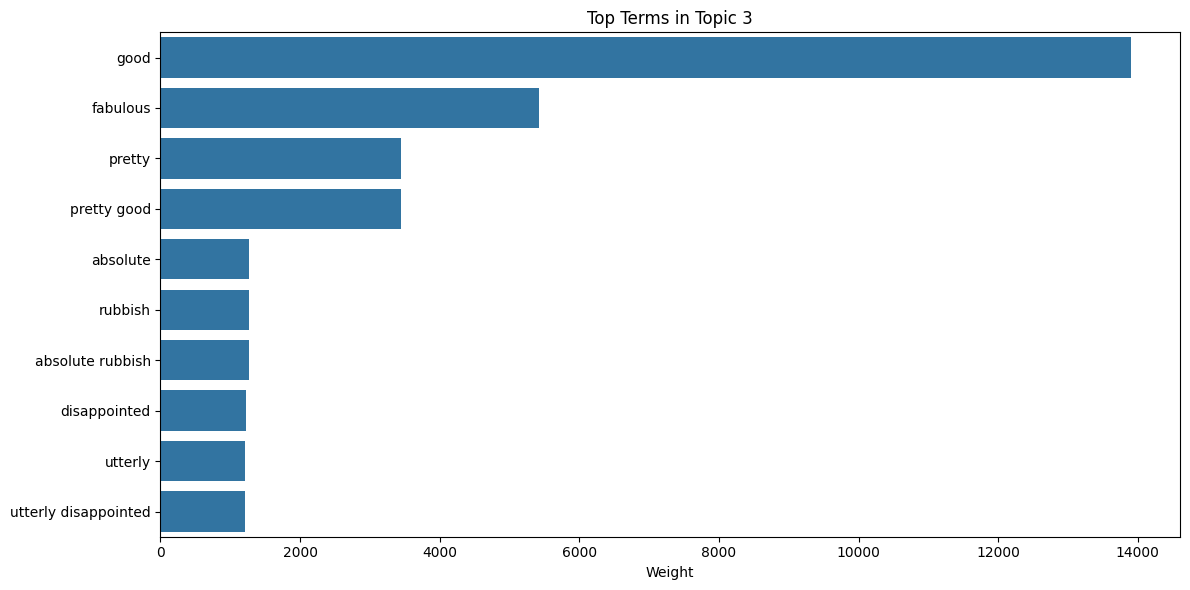

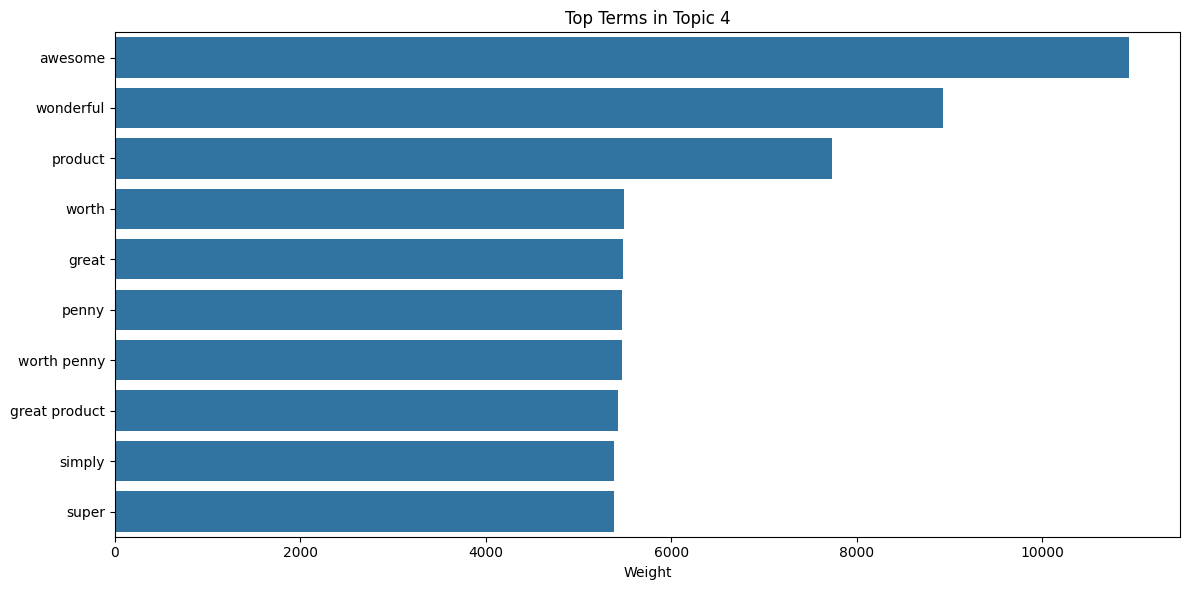

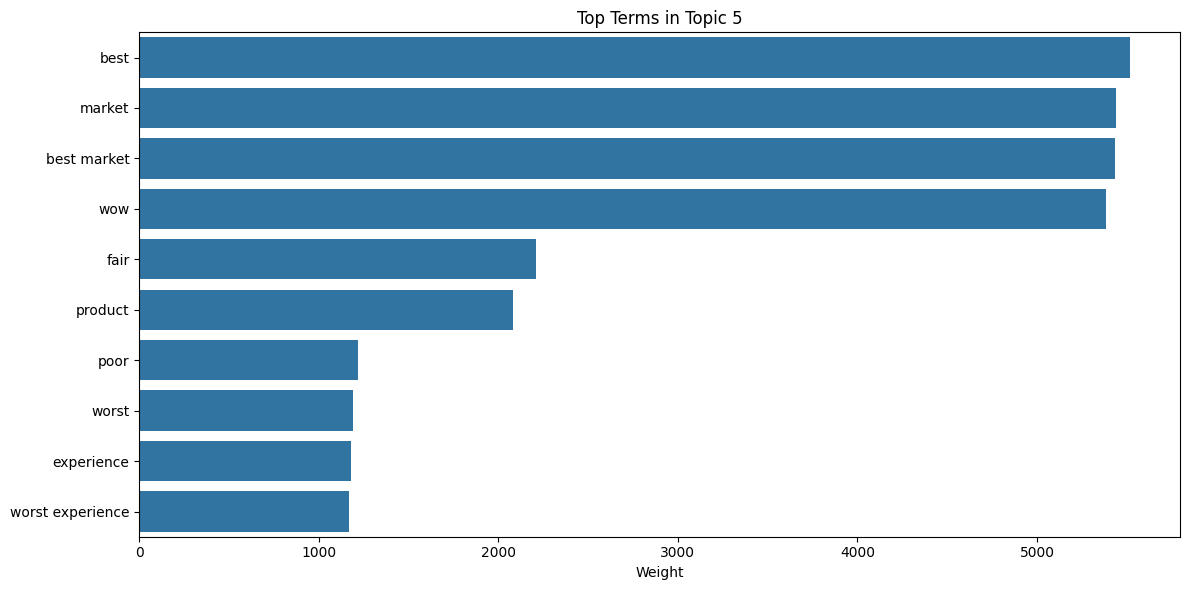

In [45]:
# Plot topic distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='dominant_topic', data=df, palette='viridis')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic Number')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Visualize topic-term weights for each topic
for i in range(n_topics):
    plt.figure(figsize=(12, 6))
    topic_weights = lda_model.components_[i]
    top_indices = topic_weights.argsort()[:-11:-1]
    top_terms = [feature_names[idx] for idx in top_indices]
    top_weights = [topic_weights[idx] for idx in top_indices]

    sns.barplot(x=top_weights, y=top_terms)
    plt.title(f'Top Terms in Topic {i+1}')
    plt.xlabel('Weight')
    plt.tight_layout()
    plt.show()

## Text Classification

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.86      0.88      4287
     neutral       0.99      0.53      0.69     13287
    positive       0.85      0.99      0.91     39389

    accuracy                           0.87     56963
   macro avg       0.92      0.79      0.83     56963
weighted avg       0.89      0.87      0.86     56963



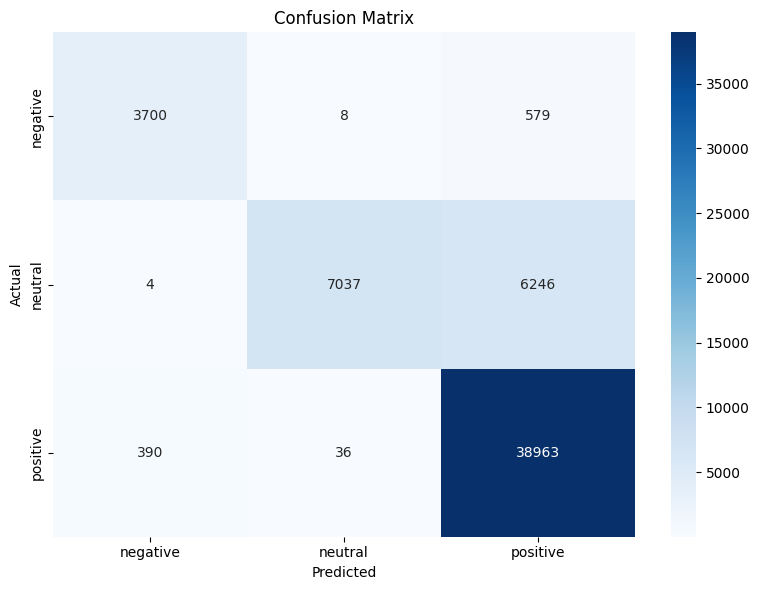

In [46]:
# Check if there's a target column for classification (e.g., sentiment or categories)
target_column = 'sentiment_category'  # Replace with actual column name if different

if target_column in df.columns:
    # Prepare features using TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    X = tfidf_vectorizer.fit_transform(df['processed_text'])
    y = df[target_column]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train Naive Bayes model
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = nb_model.predict(X_test)

    # Print classification report
    print("Naive Bayes Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=nb_model.classes_,
                yticklabels=nb_model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.94      0.93      4287
     neutral       0.99      1.00      1.00     13287
    positive       0.99      0.99      0.99     39389

    accuracy                           0.99     56963
   macro avg       0.97      0.97      0.97     56963
weighted avg       0.99      0.99      0.99     56963



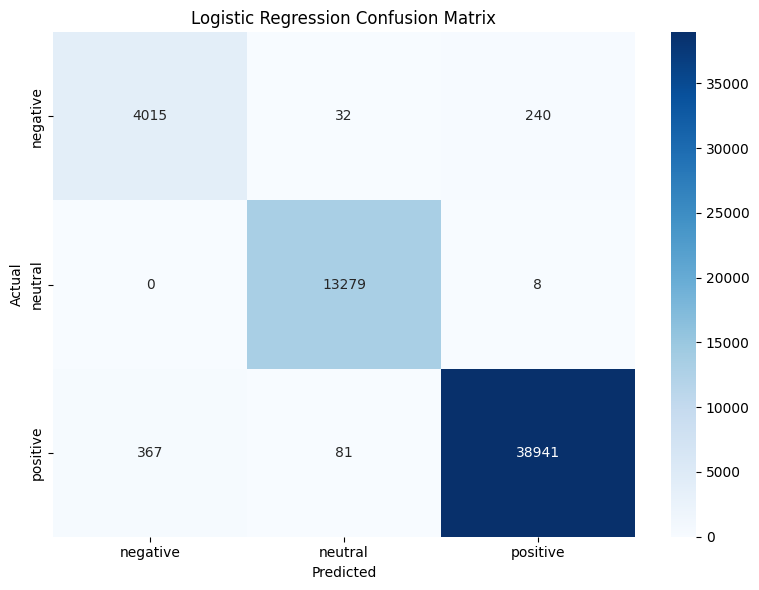

In [47]:
    # Try Logistic Regression as well
    lr_model = LogisticRegression(max_iter=1000, random_state=42)
    lr_model.fit(X_train, y_train)

    # Predict and evaluate
    lr_y_pred = lr_model.predict(X_test)

    # Print classification report
    print("\nLogistic Regression Classification Report:")
    print(classification_report(y_test, lr_y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    lr_cm = confusion_matrix(y_test, lr_y_pred)
    sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=lr_model.classes_,
                yticklabels=lr_model.classes_)
    plt.title('Logistic Regression Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

## Text Clustering

In [48]:
# Create TF-IDF vectors for clustering
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'].fillna(''))

# Reduce dimensionality for visualization (using NMF)
nmf_model = NMF(n_components=2, random_state=42)
nmf_features = nmf_model.fit_transform(tfidf_matrix)

# Add components to dataframe
df['nmf_feature1'] = nmf_features[:, 0]
df['nmf_feature2'] = nmf_features[:, 1]

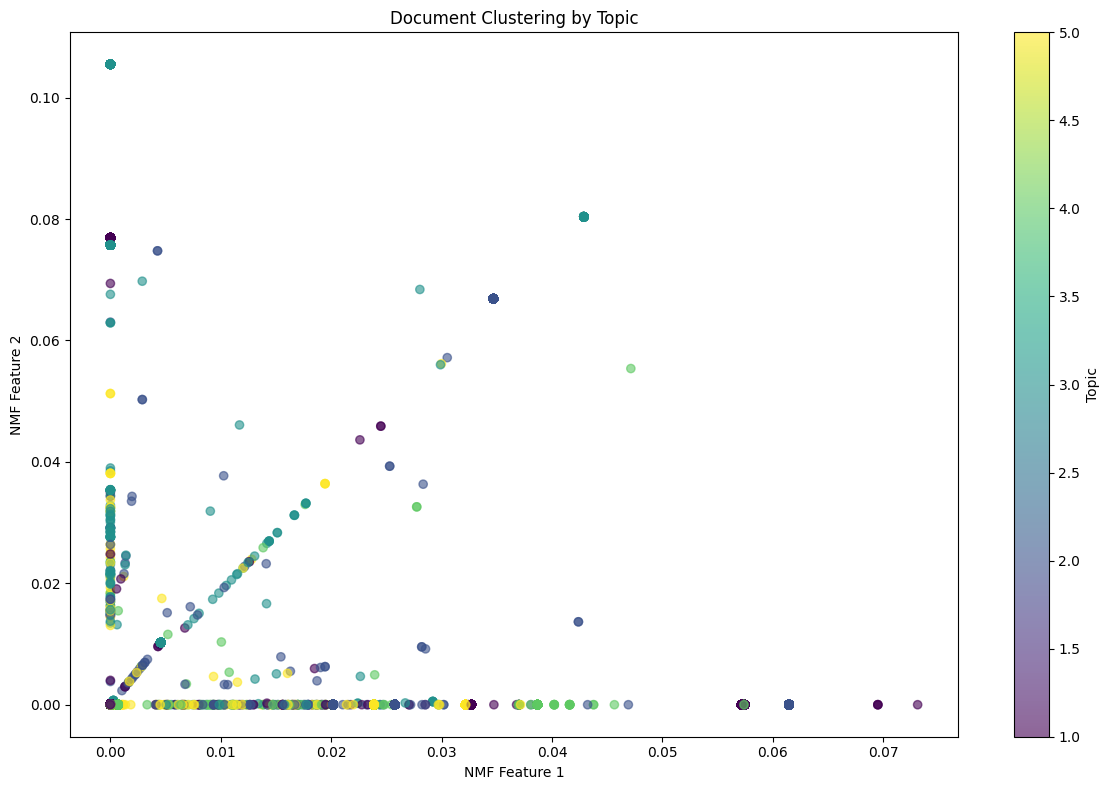

In [49]:
# Visualize clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['nmf_feature1'], df['nmf_feature2'], c=df['dominant_topic'] if 'dominant_topic' in df.columns else None, cmap='viridis', alpha=0.6)

if 'dominant_topic' in df.columns:
    plt.colorbar(scatter, label='Topic')
    plt.title('Document Clustering by Topic')
else:
    plt.title('Document Clustering')

plt.xlabel('NMF Feature 1')
plt.ylabel('NMF Feature 2')
plt.tight_layout()
plt.show()

## Co-occurrence Analysis

In [50]:
# Function to create co-occurrence matrix for top words
def get_cooccurrence_matrix(texts, top_n=30):
    # Get top words
    all_words = ' '.join(texts.fillna('')).split()
    word_counts = Counter(all_words)
    top_words = [word for word, count in word_counts.most_common(top_n)]

    # Create co-occurrence matrix
    cooccurrence = np.zeros((len(top_words), len(top_words)))
    word_to_idx = {word: i for i, word in enumerate(top_words)}

    for text in texts:
        if not isinstance(text, str) or not text.strip():
            continue

        words = text.split()
        for i, word1 in enumerate(words):
            if word1 not in top_words:
                continue
            # Look at 5-word window around the current word
            window_start = max(0, i - 5)
            window_end = min(len(words), i + 6)
            for j in range(window_start, window_end):
                if i != j and j < len(words):
                    word2 = words[j]
                    if word2 in top_words:
                        idx1 = word_to_idx[word1]
                        idx2 = word_to_idx[word2]
                        cooccurrence[idx1, idx2] += 1

    return cooccurrence, top_words

# Generate co-occurrence matrix
cooccurrence_matrix, top_words = get_cooccurrence_matrix(df['processed_text'], top_n=20)

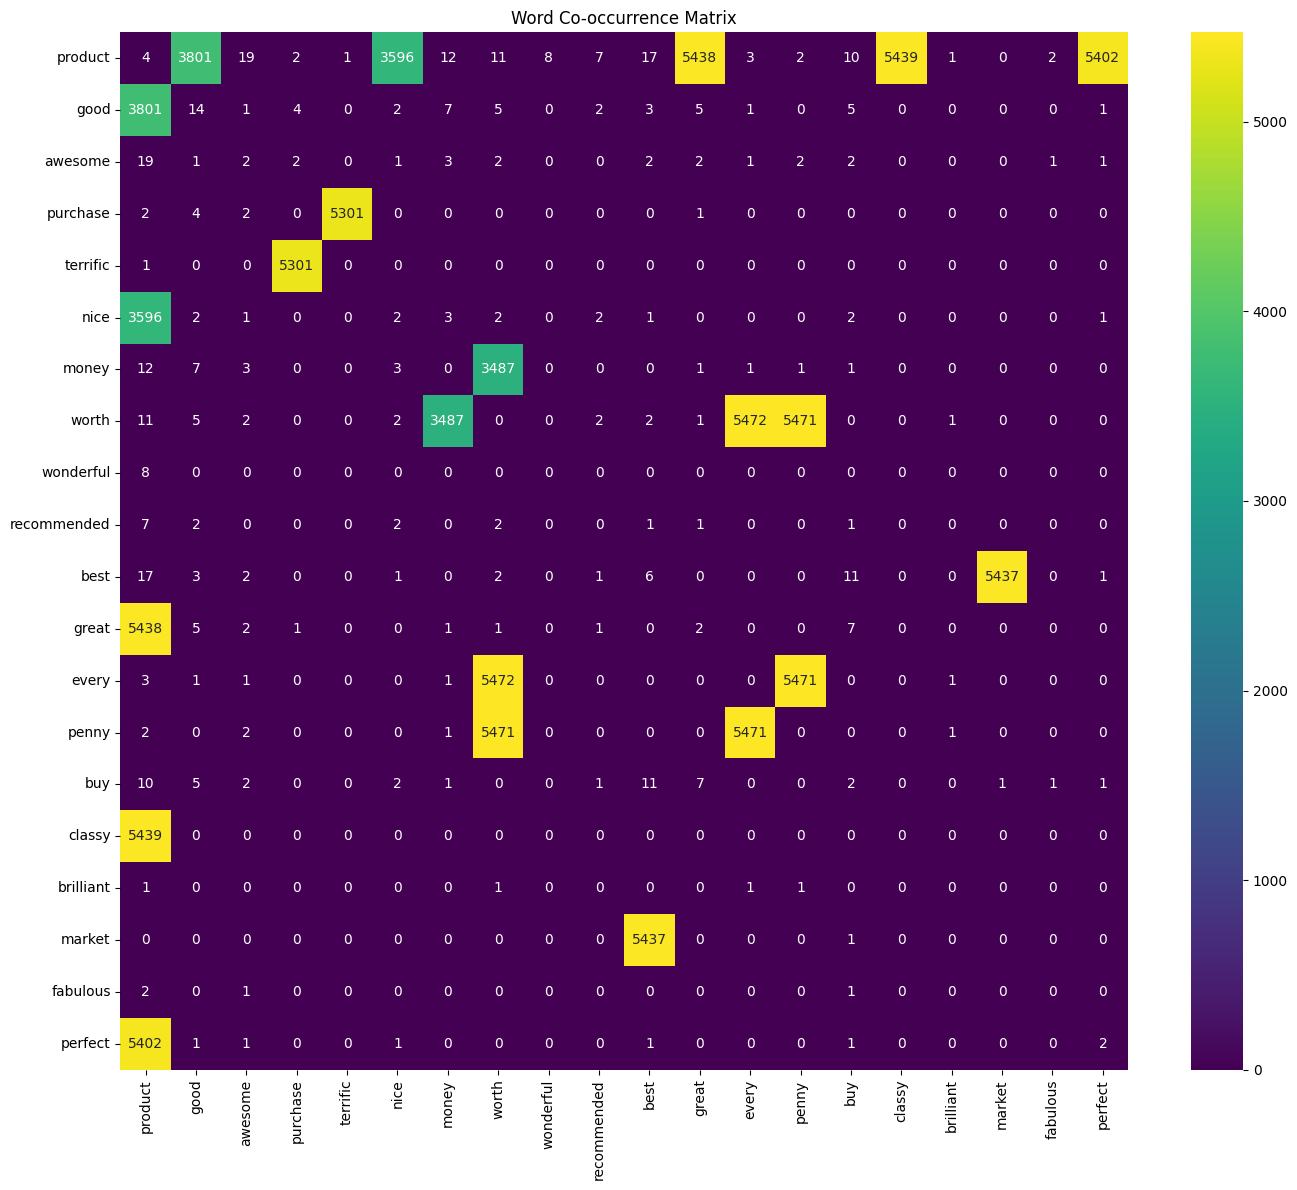

In [51]:
# Plot co-occurrence heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='.0f', cmap='viridis',
           xticklabels=top_words, yticklabels=top_words)
plt.title('Word Co-occurrence Matrix')
plt.tight_layout()
plt.show()

## Entity Recognition

In [57]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to extract entities
def extract_entities(text):
    if not isinstance(text, str) or not text.strip():
        return []
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply to a sample of the dataset (adjust sample size as needed)
sample_size = min(100, len(df))  # Adjust based on dataset size
entity_sample = df.sample(sample_size, random_state=42)

entity_sample['entities'] = entity_sample[text_column].apply(extract_entities)

# Count entity types
all_entities = []
for entities in entity_sample['entities']:
    all_entities.extend([ent[1] for ent in entities])  # Extract entity types

entity_counts = Counter(all_entities)

# Display entity type distribution
print("Entity Type Distribution:")
entity_df = pd.DataFrame(list(entity_counts.items()), columns=['Entity Type', 'Count'])
entity_df = entity_df.sort_values('Count', ascending=False)
display(entity_df)

Entity Type Distribution:


,Entity Type,Count
0,ORG,3


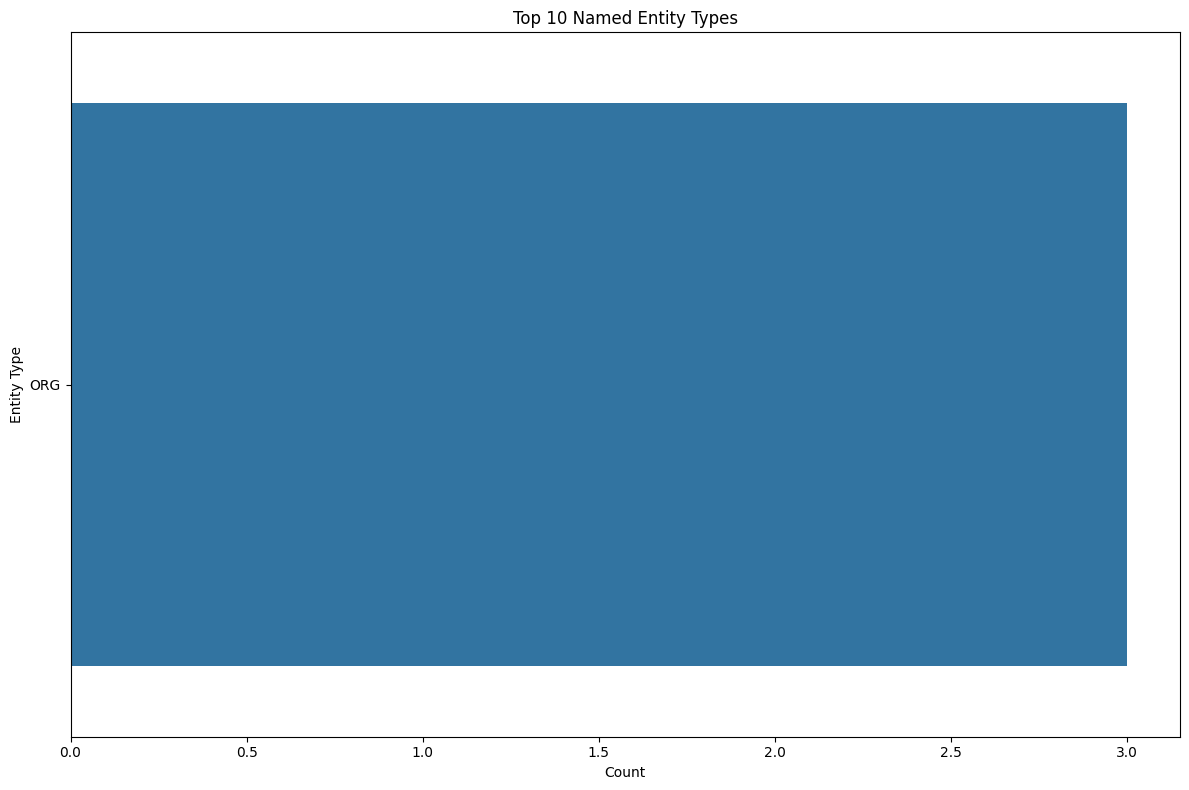

In [56]:
# Plot entity distribution
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Entity Type', data=entity_df.head(10))
plt.title('Top 10 Named Entity Types')
plt.tight_layout()
plt.show()

# Extract specific entity types if needed (e.g., organizations)
def extract_specific_entities(entities, entity_type):
    return [ent[0] for ent in entities if ent[1] == entity_type]

## Enhanced Visualizations for Text Analytics

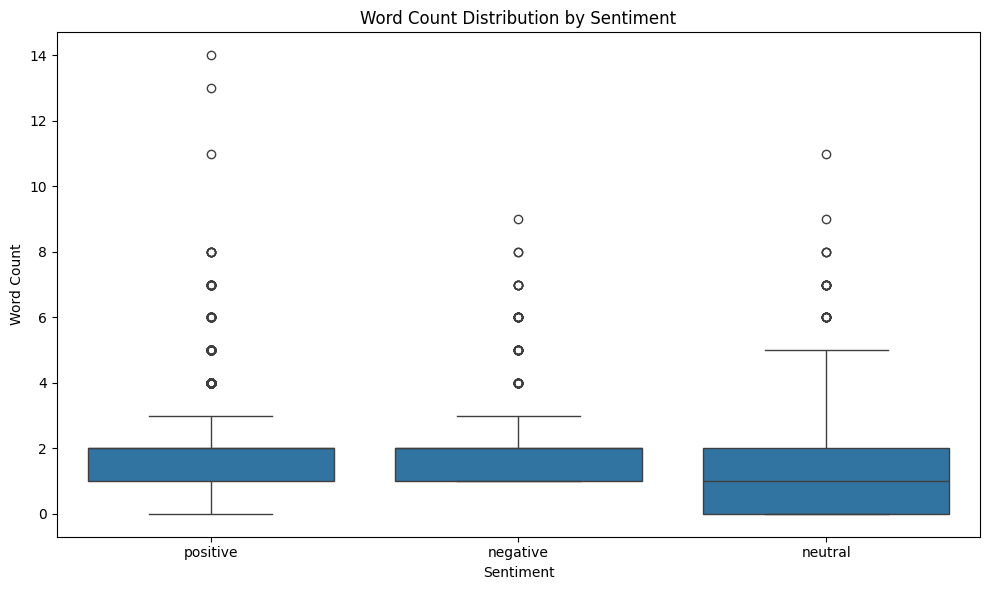

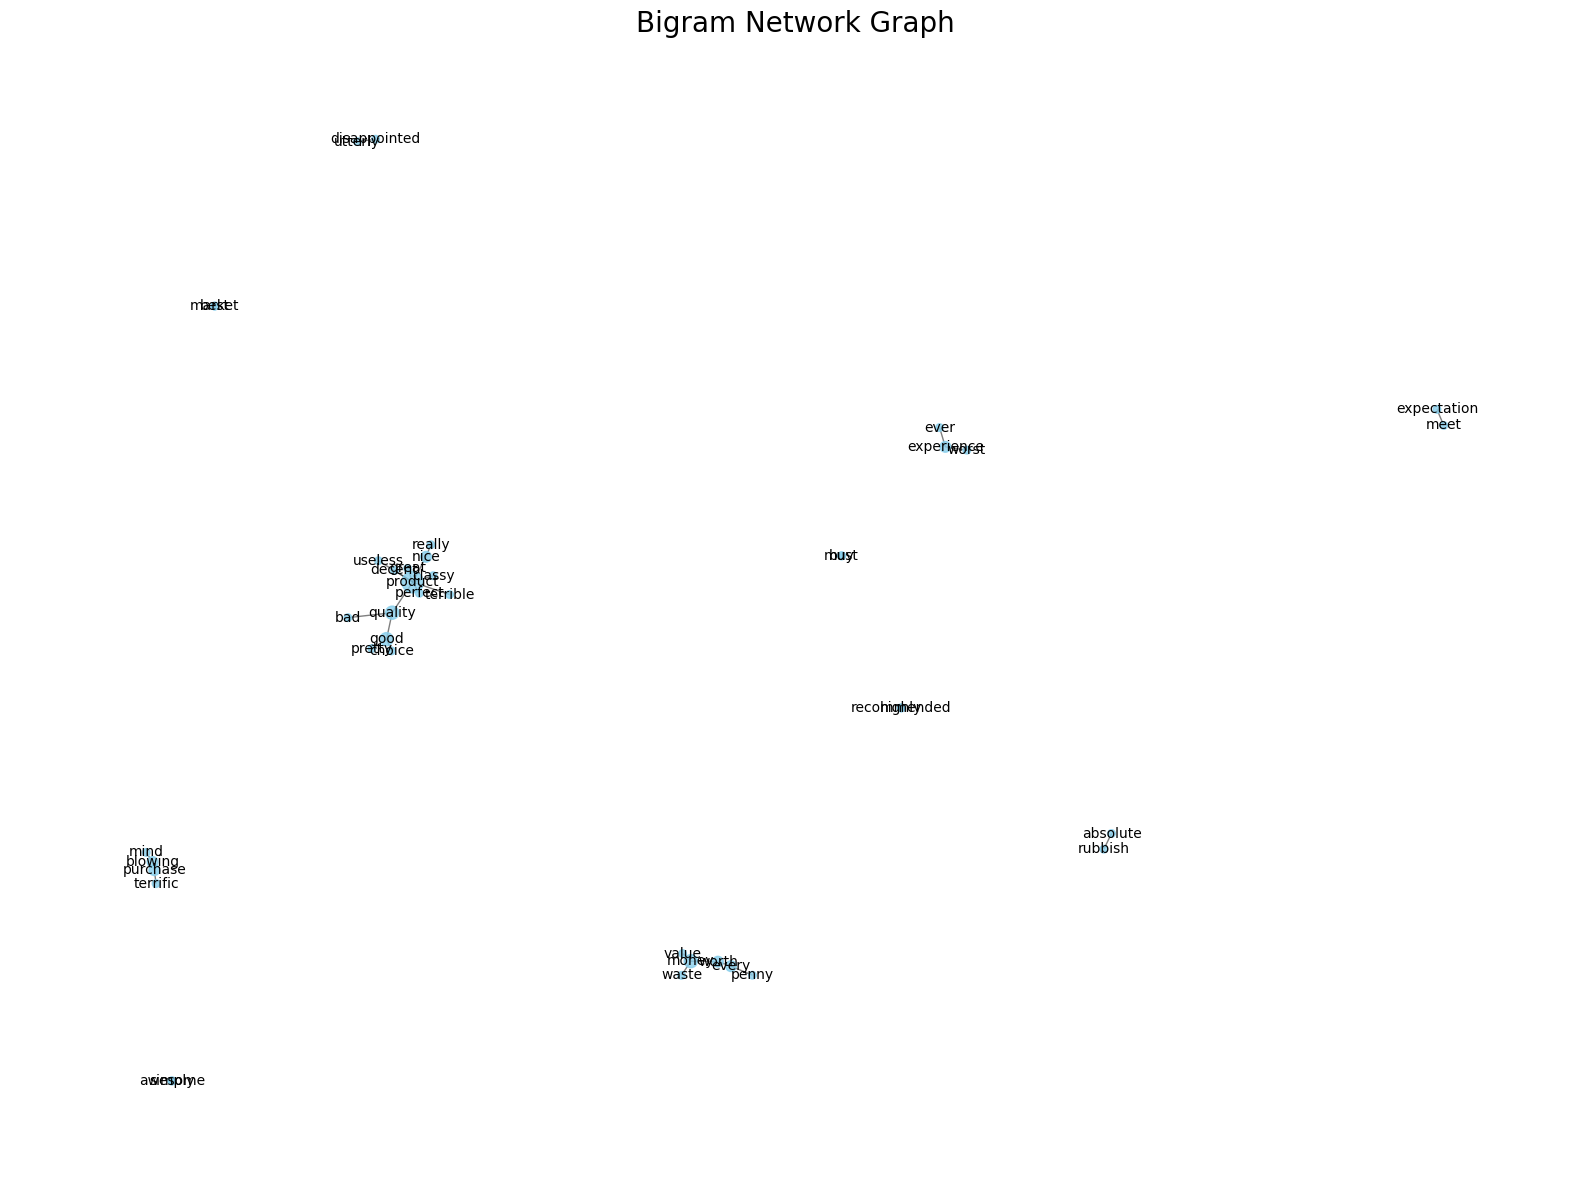

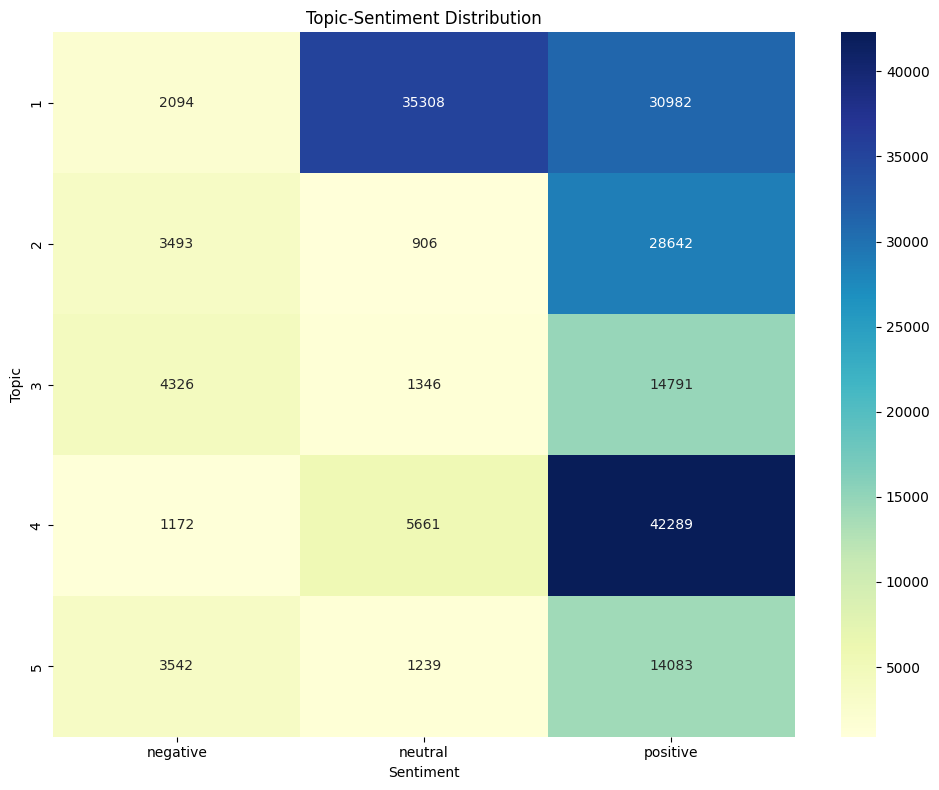

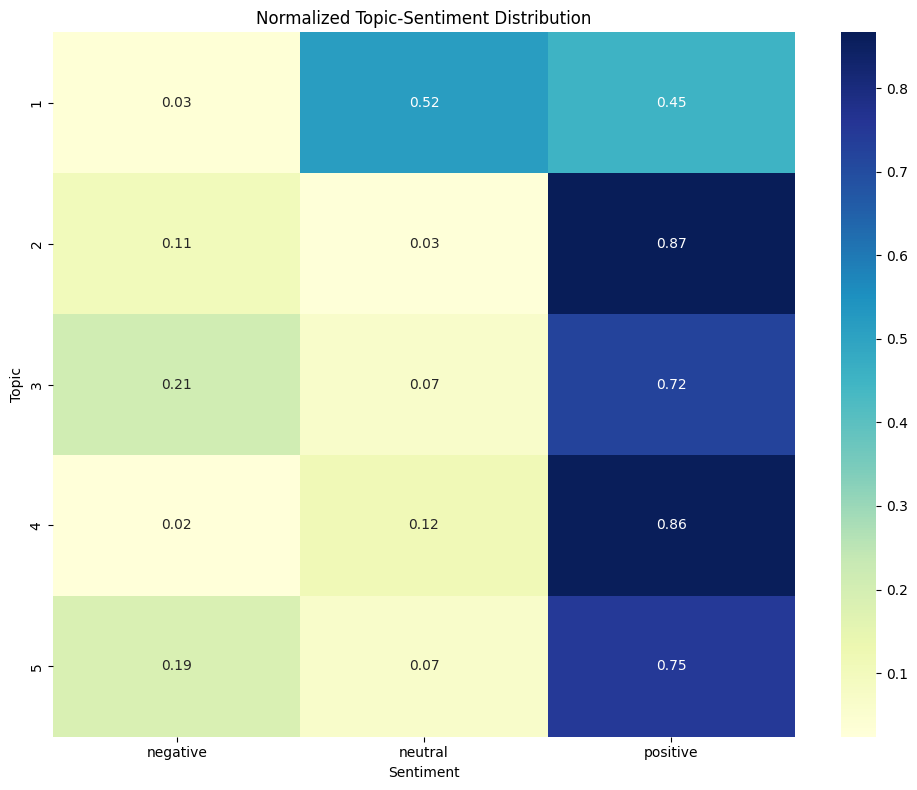

In [72]:
# 1. Sentiment Analysis by Text Length
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment_category', y='word_count', data=df)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.tight_layout()
plt.show()

# 2. Topic Distribution over Time (if date column exists)
if 'date' in df.columns:
    # Convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # Group by date and topic
    df['year_month'] = df['date'].dt.to_period('M')
    topic_time = df.groupby(['year_month', 'dominant_topic']).size().unstack()

    # Plot stacked area chart
    plt.figure(figsize=(14, 8))
    topic_time.plot.area(stacked=True, alpha=0.7, figsize=(14, 8))
    plt.title('Topic Distribution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Document Count')
    plt.legend(title='Topic')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 3. Bigram Network Graph
try:
    import networkx as nx

    # Create bigram network
    bigrams_list = []
    for text in df['processed_text'].fillna(''):
        tokens = text.split()
        bigrams_list.extend(list(zip(tokens, tokens[1:])))

    # Count bigram frequencies
    bigram_counts = Counter(bigrams_list)

    # Create network graph
    G = nx.Graph()

    # Add edges with weights based on frequency (only for top bigrams)
    for bigram, count in bigram_counts.most_common(30):  # Adjust number as needed
        G.add_edge(bigram[0], bigram[1], weight=count)

    # Calculate node size based on degree
    degrees = dict(nx.degree(G))
    node_sizes = [degrees[node] * 30 for node in G.nodes()]

    # Plot the graph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=0.15)  # Position nodes using force-directed layout

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title('Bigram Network Graph', fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except ImportError:
    print("NetworkX not installed. To create network graphs, install networkx package.")

# 4. Topic-Sentiment Heat Map
if 'dominant_topic' in df.columns and 'sentiment_category' in df.columns:
    # Create cross-tabulation
    topic_sentiment = pd.crosstab(df['dominant_topic'], df['sentiment_category'])

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(topic_sentiment, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Topic-Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()

    # Normalize to see proportions
    topic_sentiment_norm = topic_sentiment.div(topic_sentiment.sum(axis=1), axis=0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(topic_sentiment_norm, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title('Normalized Topic-Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()

## Results Summary and Interpretation

In [73]:
# Create a summary of key findings
print("TEXT ANALYTICS SUMMARY REPORT")
print("="*50)

print("\n1. CORPUS STATISTICS")
print("-"*50)
print(f"Total documents: {len(df)}")
print(f"Average document length: {df['word_count'].mean():.1f} words")
print(f"Total unique words: {len(set(' '.join(df['processed_text'].fillna('')).split()))}")

print("\n2. SENTIMENT ANALYSIS")
print("-"*50)
sentiment_summary = df['sentiment_category'].value_counts(normalize=True).to_dict()
for sentiment, proportion in sentiment_summary.items():
    print(f"{sentiment.capitalize()}: {proportion:.1%}")

if 'dominant_topic' in df.columns:
    print("\n3. TOPIC DISTRIBUTION")
    print("-"*50)
    topic_summary = df['dominant_topic'].value_counts(normalize=True).to_dict()
    for topic, proportion in topic_summary.items():
        # Get top words for this topic
        topic_idx = int(topic) - 1  # Convert to 0-based indexing
        if topic_idx < lda_model.components_.shape[0]:
            top_words = [feature_names[i] for i in lda_model.components_[topic_idx].argsort()[:-6:-1]]
            print(f"Topic {topic} ({proportion:.1%}): {', '.join(top_words)}")

print("\n4. KEY INSIGHTS")
print("-"*50)
# Example insights (would be customized based on actual findings)
print("• The most frequent words across all documents are:", ", ".join([word for word, _ in top_unigrams[:5]]))
print("• The most common bigrams suggest key themes:", ", ".join([bigram for bigram, _ in top_bigrams[:3]]))

if 'dominant_topic' in df.columns and 'sentiment_category' in df.columns:
    # Find topics with highest positive/negative sentiment
    topic_sentiment = pd.crosstab(df['dominant_topic'], df['sentiment_category'])

    positive_topics = topic_sentiment['positive'].sort_values(ascending=False).index[:2]
    negative_topics = topic_sentiment['negative'].sort_values(ascending=False).index[:2]

    print(f"• Topics {list(positive_topics)} have the highest positive sentiment counts")
    print(f"• Topics {list(negative_topics)} have the highest negative sentiment counts")

print("\n5. RECOMMENDATIONS")
print("-"*50)
print("• Consider further investigation of the relationship between text length and sentiment")
print("• Explore additional context around frequently co-occurring terms")
print("• Topic model could be refined to better separate distinct themes")

TEXT ANALYTICS SUMMARY REPORT

1. CORPUS STATISTICS
--------------------------------------------------
Total documents: 189874
Average document length: 1.5 words
Total unique words: 1029

2. SENTIMENT ANALYSIS
--------------------------------------------------
Positive: 68.9%
Neutral: 23.4%
Negative: 7.7%

3. TOPIC DISTRIBUTION
--------------------------------------------------
Topic 1 (36.0%): product, purchase, terrific, buy, classy
Topic 4 (25.9%): awesome, wonderful, product, worth, great
Topic 2 (17.4%): nice, product, recommended, money, brilliant
Topic 3 (10.8%): good, fabulous, pretty, pretty good, absolute
Topic 5 (9.9%): best, market, best market, wow, fair

4. KEY INSIGHTS
--------------------------------------------------
• The most frequent words across all documents are: product, good, awesome, purchase, terrific
• The most common bigrams suggest key themes: worth every, every penny, classy product
• Topics [4, 1] have the highest positive sentiment counts
• Topics [3, 5]

## 16. Conclusion

In this notebook, we've implemented a comprehensive text analytics pipeline that includes:

1. Data loading and preprocessing
2. Basic text statistics and exploratory analysis
3. Word frequency analysis with visualizations
4. Sentiment analysis using VADER
5. Topic modeling with LDA
6. Text classification (if applicable)
7. Text clustering and visualization
8. Co-occurrence analysis
9. Enhanced visualizations specific to text analytics
10. Summary of key findings and insights

This implementation provides a solid foundation for text analytics tasks and can be customized further based on specific project requirements.

The visualizations offer intuitive ways to understand patterns in the text data, sentiment distribution, and topic relationships.

For further improvements, consider:

1. Exploring advanced text embedding techniques like Word2Vec, GloVe, or BERT
2. Implementing more sophisticated classification models
3. Adding time-series analysis if temporal data is available
4. Creating interactive visualizations for deeper exploration
5. Exploring domain-specific lexicons for improved sentiment analysis